## Предобработка и анализ данных

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv()

True

In [4]:
dst_host = os.environ.get('DB_DESTINATION_HOST')
dst_port = os.environ.get('DB_DESTINATION_PORT')
dst_username = os.environ.get('DB_DESTINATION_USER')
dst_password = os.environ.get('DB_DESTINATION_PASSWORD')
dst_db = os.environ.get('DB_DESTINATION_NAME')

In [5]:
dst_conn = create_engine(f'postgresql://{dst_username}:{dst_password}@{dst_host}:{dst_port}/{dst_db}')

### Функции предобработки данных

In [11]:
# Извелечение и объединение исходных данных

def extract(conn):
    sql = f"""
        select
            f.id, f.floor, f.kitchen_area, f.living_area, f.rooms, f.is_apartment, f.studio, f.total_area, f.price,
            b.build_year, b.building_type_int, b.latitude, b.longitude, b.ceiling_height, b.flats_count, b.floors_total, b.has_elevator
        from flats as f
        left join buildings as b on f.building_id = b.id
        """

    data = pd.read_sql(sql, conn)
    return data

In [12]:
# Предварительная трансформация объединенной таблицы

def transform(data):
    # Переименовываем колонку id у квартир на flat_id (т.к. id - это индексная колонка в БД)
    data.rename(columns={'id': 'flat_id'}, inplace=True)
    
    # Удаляем строки с пустыми, отрицательными и нулевыми ценами
    data = data[~(data['price'].isnull() | (data['price'] <= 0))]
    
    # Добавляем target = ln(1 + price)
    data['target'] = np.log1p(data['price'])
    
    return data

In [13]:
# Удаление строк-дубликатов

def remove_duplicates(data):
    cols_to_check = data.columns.drop(['flat_id']).tolist()
    duplicated_rows = data.duplicated(subset=cols_to_check, keep=False)
    data = data[~duplicated_rows].reset_index(drop=True)
    return data

In [14]:
# Заполнение пропусков в признаках

def fill_missing_values(data):
    cols_with_nans = data.isnull().sum()
    cols_with_nans = cols_with_nans[cols_with_nans > 0].index
    
    # 1. В колонке flat_id не может быть пропусков, т.к. она была индексом в исходной таблице flats
    # 2. В цикл не попадают колонки price и target, т.к. ранее мы уже удалили строки с пустыми ценами
    for col in cols_with_nans:
        if data[col].dtype in ['float']:
            fill_value = data[col].mean()
        elif data[col].dtype in ['int', 'bool', 'object']:
            fill_value = data[col].mode().iloc[0]
        
        data[col].fillna(value=fill_value, inplace=True)
    
    return data

In [37]:
# Удаление строк с выбросами у количественных признаков

def remove_outliers(data):
    num_cols = data.select_dtypes(['int', 'float']).drop(
        columns=['flat_id', 'building_type_int', 'price', 'target']
    ).columns
    threshold = 1.5
    potential_outliers = pd.DataFrame()
    
    for col in num_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        margin = threshold * IQR
        lower = Q1 - margin
        upper = Q3 + margin
        potential_outliers[col] = ~data[col].between(lower, upper)
        
    outliers = potential_outliers.any(axis=1)
    return data[~outliers]

### Проводим предобработку и анализ данных

Объединяем исходные данные в одну таблицу

In [16]:
data_1 = extract(dst_conn)

In [17]:
data_1.head()

,id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,9,9.9,19.900000,1,False,False,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,True
1,1,7,0.0,16.600000,1,False,False,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,True
2,2,9,9.0,32.000000,2,False,False,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,True
3,3,1,10.1,43.099998,3,False,False,76.000000,20000000,2002,4,55.672016,37.570877,2.64,771,17,True
4,4,3,3.0,14.000000,1,False,False,24.000000,5200000,1971,1,55.808807,37.707306,2.60,208,9,True


In [18]:
data_1.shape

(141362, 17)

In [19]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141362 entries, 0 to 141361
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 141362 non-null  int64  
 1   floor              141362 non-null  int64  
 2   kitchen_area       141362 non-null  float64
 3   living_area        141362 non-null  float64
 4   rooms              141362 non-null  int64  
 5   is_apartment       141362 non-null  bool   
 6   studio             141362 non-null  bool   
 7   total_area         141362 non-null  float64
 8   price              141362 non-null  int64  
 9   build_year         141362 non-null  int64  
 10  building_type_int  141362 non-null  int64  
 11  latitude           141362 non-null  float64
 12  longitude          141362 non-null  float64
 13  ceiling_height     141362 non-null  float64
 14  flats_count        141362 non-null  int64  
 15  floors_total       141362 non-null  int64  
 16  ha

Переименовываем id квартир на flat_id и добавляем новый target

In [20]:
data_2 = transform(data_1)

In [21]:
data_2.head()

,flat_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,target
0,0,9,9.9,19.900000,1,False,False,35.099998,9500000,1965,6,55.717113,37.781120,2.64,84,12,True,16.066802
1,1,7,0.0,16.600000,1,False,False,43.000000,13500000,2001,2,55.794849,37.608013,3.00,97,10,True,16.418200
2,2,9,9.0,32.000000,2,False,False,56.000000,13500000,2000,4,55.740040,37.761742,2.70,80,10,True,16.418200
3,3,1,10.1,43.099998,3,False,False,76.000000,20000000,2002,4,55.672016,37.570877,2.64,771,17,True,16.811243
4,4,3,3.0,14.000000,1,False,False,24.000000,5200000,1971,1,55.808807,37.707306,2.60,208,9,True,15.464169


In [22]:
data_2.shape

(141362, 18)

Проверяем наличие дубликатов

In [23]:
cols_to_check = data_2.columns.drop(['flat_id']).tolist()
duplicated_rows = data_2.duplicated(subset=cols_to_check, keep=False)
duplicated_data = data_2[duplicated_rows]
print('Кол-во строк-дубликатов: ', len(duplicated_data))

Кол-во строк-дубликатов:  17425


Удаляем дубликаты

In [24]:
data_3 = remove_duplicates(data_2)

In [25]:
data_3.shape

(123937, 18)

Проверяем наличие пропусков в признаковых данных

In [26]:
data_3.isnull().sum()

flat_id              0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
target               0
dtype: int64

In [27]:
data_4 = fill_missing_values(data_3)

In [28]:
data_4.shape

(123937, 18)

Смотрим гистограммы булевских признаков

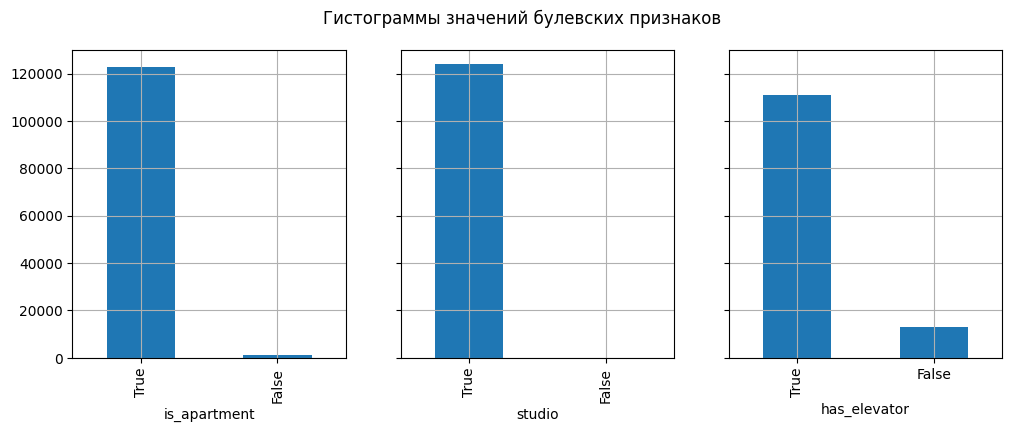

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,4), sharey=True, sharex=True)

data_4['is_apartment'].value_counts().plot(kind='bar', ax=ax1)
data_4['studio'].value_counts().plot(kind='bar', ax=ax2)
data_4['has_elevator'].value_counts().plot(kind='bar', ax=ax3)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

plt.suptitle('Гистограммы значений булевских признаков')
plt.show()

Таким образом, признак studio можно будет исключить.

Проверим гистограммы целочисленных признаков

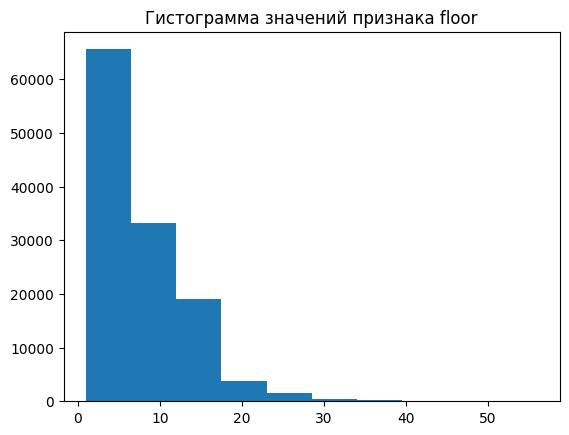

In [30]:
plt.hist(data_4['floor'])
plt.title('Гистограмма значений признака floor')
plt.show()

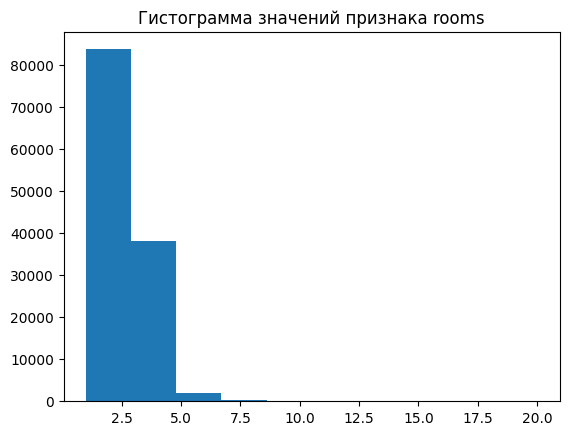

In [31]:
plt.hist(data_4['rooms'])
plt.title('Гистограмма значений признака rooms')
plt.show()

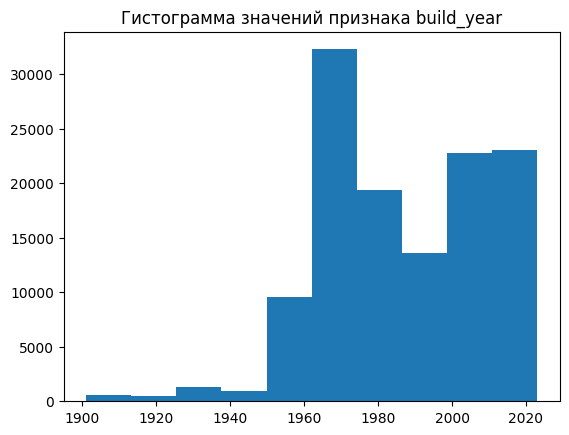

In [32]:
plt.hist(data_4['build_year'])
plt.title('Гистограмма значений признака build_year')
plt.show()

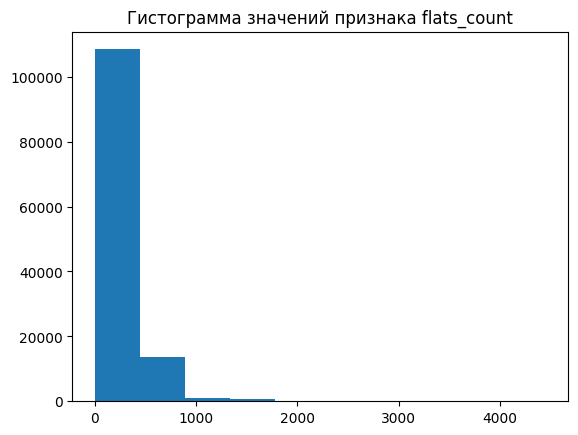

In [33]:
plt.hist(data_4['flats_count'])
plt.title('Гистограмма значений признака flats_count')
plt.show()

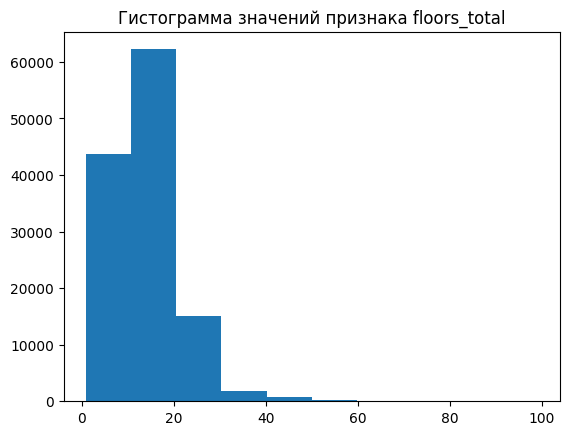

In [34]:
plt.hist(data_4['floors_total'])
plt.title('Гистограмма значений признака floors_total')
plt.show()

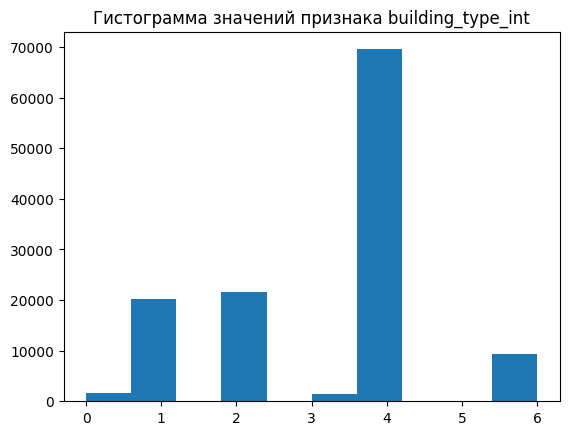

In [35]:
plt.hist(data_4['building_type_int'])
plt.title('Гистограмма значений признака building_type_int')
plt.show()

В соответствии с приведенными гистограммами будем считать признак building_type_int категориальными, а остальные целочисленные признаки количественными. При этом вместо build_year перед обучением модели будем формировать признак возраст здания - building_age, как разность между текущим годом и build_year.

Проверяем наличие выбросов у количественных признаков

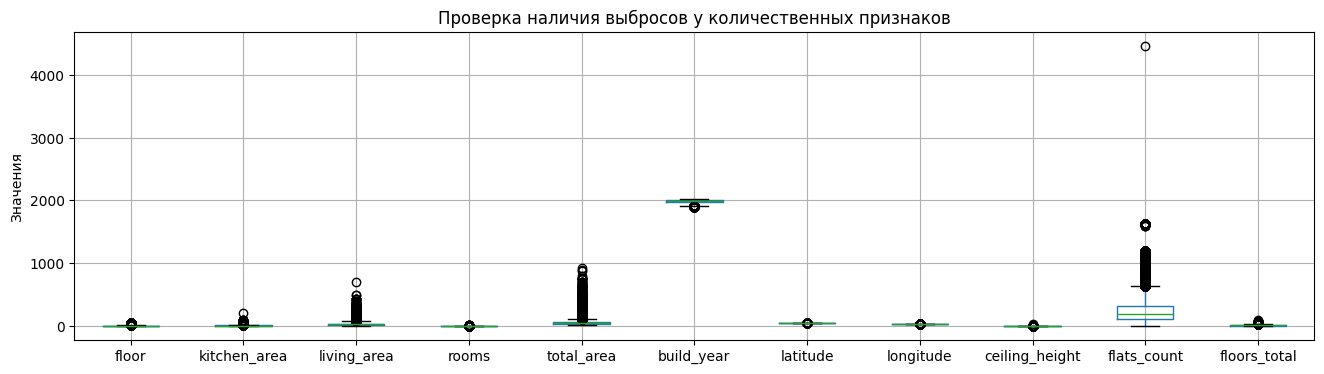

In [38]:

fig, ax = plt.subplots(ncols=1, figsize=(16,4)) 

data_4[[
    'floor', 
    'kitchen_area', 
    'living_area', 
    'rooms', 
    'total_area', 
    'build_year', 
    'latitude', 
    'longitude',
    'ceiling_height',
    'flats_count',
    'floors_total'
]].boxplot(ax=ax)

plt.ylabel('Значения')
plt.title('Проверка наличия выбросов у количественных признаков')
plt.show()

Из графика следует, что самые существенные выбросы имеются у признаков living_area, total_area и flats_count.

Удаляем строки с выбросами и получаем очищенный датасет

In [40]:
clean_data = remove_outliers(data_4)

In [41]:
clean_data.shape

(99740, 18)

In [42]:
clean_data.describe()

,flat_id,floor,kitchen_area,living_area,rooms,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,target
count,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000,9.974000e+04,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000,99740.000000
mean,69744.545699,6.742320,8.120362,27.908662,1.967114,52.402821,1.271694e+07,1984.153258,3.484339,55.728830,37.603148,2.693106,222.017485,13.035141,16.239943
std,41175.104554,4.509732,3.065108,14.807722,0.824230,17.105786,4.388462e+07,19.589236,1.432481,0.102409,0.147503,0.136023,133.675928,5.149447,0.474819
min,0.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01,1914.000000,0.000000,55.427238,37.190639,2.450000,1.000000,1.000000,2.484907
25%,33730.750000,3.000000,6.000000,19.000000,1.000000,38.500000,8.590000e+06,1968.000000,2.000000,55.650444,37.496704,2.640000,111.000000,9.000000,15.966109
50%,69750.500000,6.000000,8.400000,28.799999,2.000000,49.700001,1.099000e+07,1979.000000,4.000000,55.718822,37.590794,2.640000,192.000000,12.000000,16.212496
75%,105040.250000,10.000000,10.000000,37.000000,3.000000,62.000000,1.430000e+07,2002.000000,4.000000,55.812847,37.719837,2.740000,298.000000,17.000000,16.475770
max,141361.000000,20.000000,16.300000,74.000000,6.000000,118.699997,9.799999e+09,2023.000000,6.000000,56.011032,37.946411,3.000000,638.000000,29.000000,23.005648


Видим, что колонки latitude, longitude и ceiling_height имеют наименьшую дисперсию. Оценим их корреляцию с целевым признаком

In [43]:
print(pearsonr(clean_data['latitude'], clean_data['target'])[0]) 
print(pearsonr(clean_data['longitude'], clean_data['target'])[0]) 
print(pearsonr(clean_data['ceiling_height'], clean_data['target'])[0])

0.04002186808615945
-0.1228414116560601
0.32035999836353823


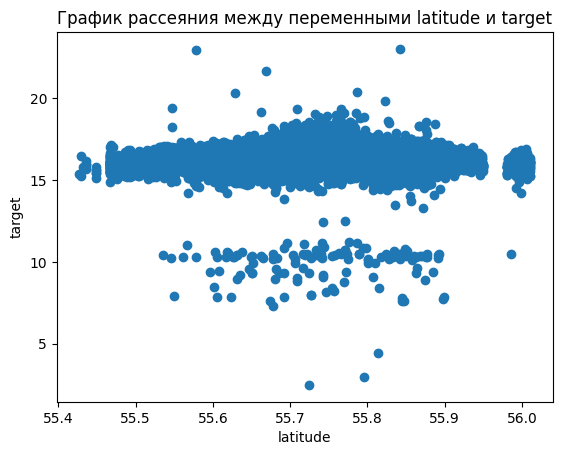

In [45]:
plt.scatter(clean_data['latitude'], clean_data['target'])
plt.xlabel('latitude')
plt.ylabel('target')
plt.title('График рассеяния между переменными latitude и target')
plt.show()

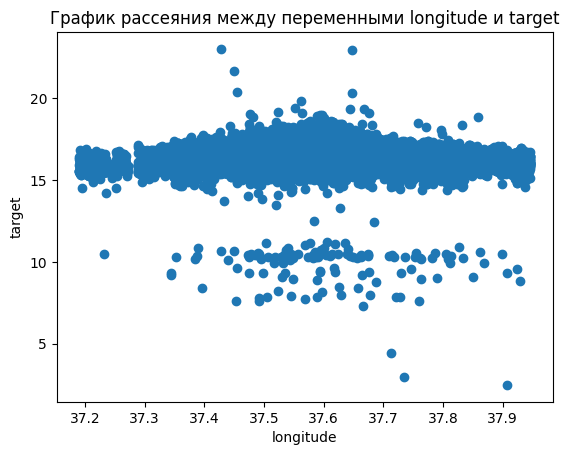

In [46]:
plt.scatter(clean_data['longitude'], clean_data['target'])
plt.xlabel('longitude')
plt.ylabel('target')
plt.title('График рассеяния между переменными longitude и target')
plt.show()

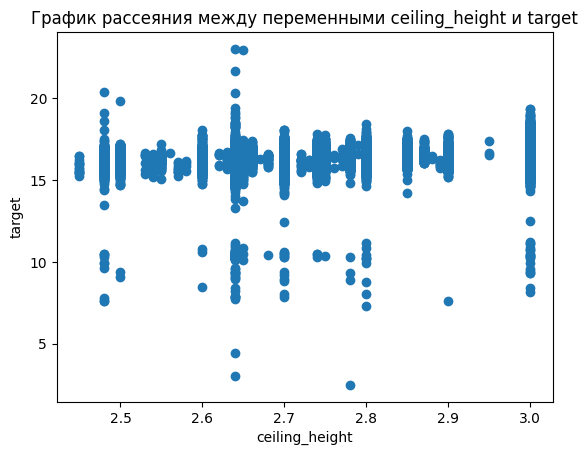

In [47]:
plt.scatter(clean_data['ceiling_height'], clean_data['target'])
plt.xlabel('ceiling_height')
plt.ylabel('target')
plt.title('График рассеяния между переменными ceiling_height и target')
plt.show()

Таким образом, признаки latitude и longitude имеют наименьшую дисперсию, являются почти константными, поэтому их можно исключить из числа признаков. Ceiling_height имеет больший разброс, поэтому его оставляем.

Оценим на мультиколлениарность признаки, связанные с площадями

In [50]:
print(pearsonr(clean_data['living_area'], clean_data['total_area'])[0]) 
print(pearsonr(clean_data['kitchen_area'], clean_data['total_area'])[0]) 
print(pearsonr(clean_data['living_area'], clean_data['kitchen_area'])[0])

0.6437991071480924
0.3200546708152062
0.3421370294222865


Таким образом, все эти 3 колонки лучше сохранить, т.к. между ними нет значительной корреляции.

In [48]:
dst_conn.dispose()